In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import keras

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [3]:
print(os.getcwd())

/Users/wnowak/gitt/ffc/materialHardship/Training


Set working directory to materialHardship folder.

In [4]:
os.chdir('/Users/wnowak/gitt/ffc/materialHardship/')

Import data needed for training and prediction.

In [5]:
final_over_balanced =  pd.read_pickle('Data/balanced/final_over_balanced_decimals')

In [6]:
df_prediction = pd.read_pickle('Data/df_prediction')

In [7]:
final_over_balanced =  pd.read_pickle('Data/balanced/final_over_balanced_decimals')
medians =  pd.read_pickle('Data/median_impute_df_train_with_labels')

Split datasets into training and validation sets.

In [8]:
# split data into features and labels
def split_data(df, label='materialHardship'):
    copy = df.copy() # copy df so i dont alter original df by popping
    mh = copy.pop(label) # pop label
    x_train_bal, x_valid_bal, y_train_bal, y_valid_bal = train_test_split(copy, mh, test_size=0.1) #train test split
    return x_train_bal, x_valid_bal, y_train_bal, y_valid_bal # return


# In[8]:

x_tr_bal, _, y_tr_bal, _ = split_data(final_over_balanced)

x_tr, x_val, y_tr, y_val = split_data(medians)

In [9]:
# determine which columns to use when making prediction
df_prediction_good_cols = df_prediction[x_tr.columns.values] # keep the columns that are in training data...

But we have a potential problem...we can see below that there are NA's. And there are some columns in the prediction set (and not in the test set) that have all NA's, so we can't even do mean or median imputation for these. SOOOO...

In [10]:
df_prediction_good_cols.isnull().sum().sort_values(ascending=False)[0:10]

hv3pvnbasal    2783
hv4k4a         2782
hv3a16c3_0     2780
hv3a16d3_2     2779
hv3a16d3_8     2779
hv3a16d3_7     2779
hv3a16d3_6     2779
hv3a16d3_5     2779
hv3a16d3_4     2779
hv3a16d3_3     2779
dtype: int64

It is just hv3pvnbasal that has all rows missing ({{df_prediction_good_cols.isnull().sum().sort_values(ascending=False)[0]}} out of {{df_prediction_good_cols.shape[0]}}). So let's drop that from x_train. 

In [11]:
# x_tr['hv3pvnbasal']
x_tr = x_tr.drop('hv3pvnbasal',1)
x_val = x_val.drop('hv3pvnbasal',1)
x_tr_bal = x_tr_bal.drop('hv3pvnbasal',1)

In [13]:
y_one_hot = pd.get_dummies(y_tr)

In [15]:
X = x_tr.values # train on imbalanced
# X = x_tr_bal.values # train on augmented, balanced X
# Y = y_tr_bal.values
Y = y_one_hot.values

In [17]:
y_val =  pd.get_dummies(y_val)

In [19]:
y_val = y_val.values

In [51]:
from keras.layers import Activation
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense

model = Sequential() # set up model

# add fully connected layer that go to num_nodes hidden nodes
num_nodes = 40
model.add(Dense(num_nodes, input_dim=x_tr.values.shape[1], kernel_initializer='normal'))
model.add(Activation('relu'))

# use linear combination of weights and values from previous layer to make one hot prediction
model.add(Dense(y_one_hot.shape[1]))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam')

# fit the model for num_epochs epochs. callbacks option can be set to activate early stopping
# include validation_data to measure both
calls = [EarlyStopping(monitor='val_loss',patience=2,verbose=0)]
num_epochs = 100
fitt = model.fit( X, Y, 
                 batch_size=52,
                 epochs=num_epochs, 
                 verbose=1, 
                 callbacks=calls,
                 validation_split=0.1, 
                 validation_data=(x_val.values,y_val))

Train on 1313 samples, validate on 146 samples
Epoch 1/100
1313/1313 [==============================] - 1s - loss: 14.1290 - val_loss: 12.9166

Make sure we use predictoin data frame that has same columns as training, and has no NAs...

In [28]:
df_prediction_good_cols = df_prediction[x_tr.columns.values] # keep the columns that are in training data...

In [29]:
df_prediction_good_cols.isnull().sum().sort_values(ascending=False)[0:10]

hv4k4a        2782
hv3a16c3_0    2780
hv3a16d3_5    2779
hv3a16d3_1    2779
hv3a16d3_2    2779
hv3a16d3_3    2779
hv3a16d3_4    2779
hv3a16d3_6    2779
hv3a16d3_7    2779
hv3a16d3_8    2779
dtype: int64

In [30]:
from fancyimpute import SimpleFill
filled = SimpleFill('median').complete(df_prediction_good_cols)

In [31]:
pd.DataFrame(filled).isnull().sum().sort_values(ascending=False)[0:10]

11982    0
3990     0
3999     0
3998     0
3997     0
3996     0
3995     0
3994     0
3993     0
3992     0
dtype: int64

In [32]:
# use trained model to predict
preds  = model.predict(filled,verbose=1)

2528/2783 [==========================>...] - ETA: 0s

In [34]:
preds

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [35]:
pred_df  = pd.DataFrame(preds)
pred_df.head()

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
pred_sums = pd.DataFrame(pred_df.sum(axis=0)).reset_index()
pred_sums.columns = ['score','obs']
pred_sums.head()

,score,obs
0,0,2731.0
1,1,4.0
2,2,1.0
3,3,11.0
4,4,2.0


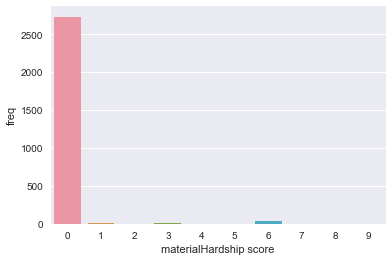

In [48]:
# check out distribution of predictions...
ax = sns.barplot(x="score", y="obs", data=pred_sums)
plt.ylabel('freq')
plt.xlabel('materialHardship score')
plt.show()

Below, I plot train and validation losses.

In [49]:
# fitt has history
hist_df = pd.DataFrame(fitt.history)
hist_df.head()

,loss,val_loss
0,11.269165,10.996299
1,11.011381,8.831833
2,10.360756,8.390241
3,9.918829,7.727854
4,8.262158,6.623875


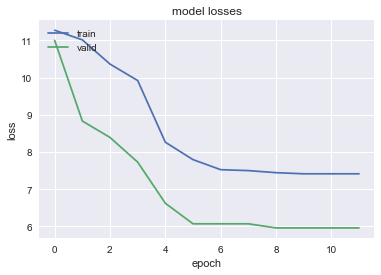

In [50]:
# summarize history for accuracy
plt.plot(fitt.history['loss'])
plt.plot(fitt.history['val_loss'])
plt.title('model losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# plt.set_ylim([0,100000])

# ax1 = plt.subplot(131)
# ax1.scatter([1, 2], [3, 4])
# ax1.set_xlim([0, 5])
# ax1.set_ylim([0, 5])